In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from models.resnet import ResNet, BasicBlock
from utils import TrainTest, PlotOutput

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
device = TrainTest.get_device()
device

'cuda'

In [3]:
# augmentations
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# datasets
trainset = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

testset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

trainset.mean = torch.tensor(mean).reshape(len(mean), 1, 1)
trainset.std = torch.tensor(std).reshape(len(std), 1, 1)

testset.mean = torch.tensor(mean).reshape(len(mean), 1, 1)
testset.std = torch.tensor(std).reshape(len(std), 1, 1)

# dataloaders
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = trainset.classes

Files already downloaded and verified
Files already downloaded and verified


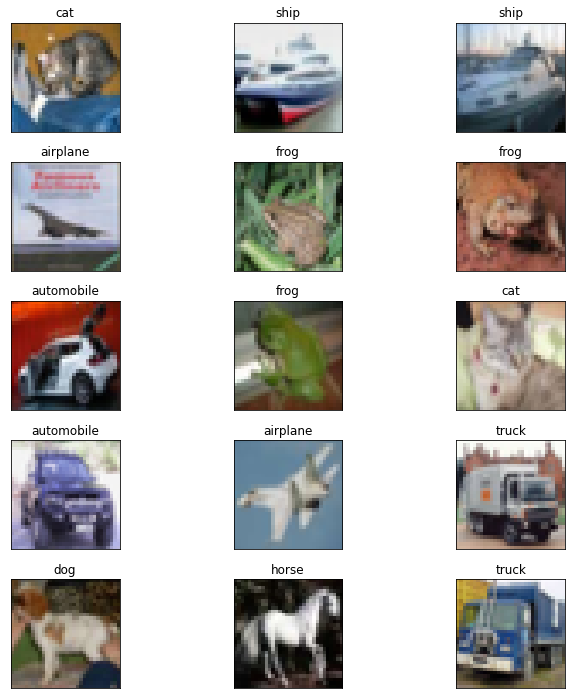

In [4]:
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(10, 10))
batch_data, batch_label = next(iter(test_loader))

t_std = torch.tensor(std).reshape(3, 1, 1)
t_mean = torch.tensor(mean).reshape(3, 1, 1)


for i in range(15):
    plt.subplot(5, 3, i+1)
    plt.tight_layout()

    # get an image - [3, 32, 32]
    # and denormalize
    image = batch_data[i] * t_std + t_mean

    # Clip the input data to the valid range [0, 1]
    image = image.clip(0, 1)
    
    # [3, 32, 32] to [32, 32, 3]
    image = image.permute(1, 2, 0)
    plt.imshow(image)
    
    plt.title(classes[batch_label[i].item()])
    plt.xticks([])
    plt.yticks([])

In [5]:
"""
RF_out = RF_in + (kernel-1) * J_in
J_out = J_in * stride
"""

'\nRF_out = RF_in + (kernel-1) * J_in\nJ_out = J_in * stride\n'

In [6]:
class Cifar38k(ResNet):
    def __init__(self, nclass=10, dropout=0.1, logit_layer="pooling"):
        super(Cifar38k, self).__init__(block=BasicBlock, 
                                       num_channels=[16,16,16,16,16], 
                                       num_blocks=[2,2,2,2], 
                                       nclass=nclass, 
                                       dropout=dropout, 
                                       logit_layer=logit_layer)

model = Cifar38k(logit_layer="pooling").to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]           2,304
      BatchNorm2d-10           [-1, 16, 32, 32]              32
       BasicBlock-11           [-1, 16, 32, 32]               0
           Conv2d-12           [-1, 16, 32, 32]           2,304
      BatchNorm2d-13           [-1, 16, 32, 32]              32
             ReLU-14           [-1, 16,

In [7]:
criterion = F.cross_entropy
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [8]:
target_layers = [model.layer4, model.layer3]
EPOCHS = 15

run = TrainTest(model=model, 
                trainloader=train_loader, 
                testloader=test_loader, 
                optimizer=optimizer, 
                criterion=criterion, 
                scheduler=scheduler,
                target_layers=target_layers)

image_idx = [15, 25, 446, 416, 96]
run(epochs=EPOCHS, cam=True, image_idx=image_idx)
# run.save_grad_cam_gif(image_idx=image_idx, output_directory="./cam_output/")

Train: Loss=1.7898 Batch_id=390 Accuracy=31.07: 100%|██████████| 391/391 [00:14<00:00, 27.15it/s]


Test set: Average loss: 1.5574, Accuracy: 4212/10000 (42.12%)



Train: Loss=1.4349 Batch_id=390 Accuracy=46.65: 100%|██████████| 391/391 [00:14<00:00, 27.78it/s]


Test set: Average loss: 1.3294, Accuracy: 5160/10000 (51.60%)



Train: Loss=1.2515 Batch_id=390 Accuracy=54.13: 100%|██████████| 391/391 [00:14<00:00, 27.12it/s]


Test set: Average loss: 1.2002, Accuracy: 5697/10000 (56.97%)



Train: Loss=1.1514 Batch_id=390 Accuracy=58.22: 100%|██████████| 391/391 [00:14<00:00, 27.31it/s]


Test set: Average loss: 1.0871, Accuracy: 6097/10000 (60.97%)



Train: Loss=1.0836 Batch_id=390 Accuracy=60.70: 100%|██████████| 391/391 [00:14<00:00, 27.07it/s]


Test set: Average loss: 1.0297, Accuracy: 6334/10000 (63.34%)



Train: Loss=1.0342 Batch_id=390 Accuracy=62.46: 100%|██████████| 391/391 [00:13<00:00, 29.11it/s]


Test set: Average loss: 1.0506, Accuracy: 6331/10000 (63.31%)



Train: Loss=0.9946 Batch_id=390 Accuracy=64.10: 100%|██████████| 391/391 [00:13<00:00, 28.65it/s]


Test set: Average loss: 0.9824, Accuracy: 6560/10000 (65.60%)



Train: Loss=0.9499 Batch_id=390 Accuracy=65.80: 100%|██████████| 391/391 [00:14<00:00, 27.10it/s]


Test set: Average loss: 0.9690, Accuracy: 6550/10000 (65.50%)



Train: Loss=0.9184 Batch_id=390 Accuracy=66.91: 100%|██████████| 391/391 [00:14<00:00, 27.92it/s]


Test set: Average loss: 1.0501, Accuracy: 6395/10000 (63.95%)



Train: Loss=0.8941 Batch_id=390 Accuracy=68.19: 100%|██████████| 391/391 [00:15<00:00, 26.01it/s]


Test set: Average loss: 0.8763, Accuracy: 6899/10000 (68.99%)



Train: Loss=0.8671 Batch_id=390 Accuracy=69.38: 100%|██████████| 391/391 [00:14<00:00, 26.88it/s]


Test set: Average loss: 0.8639, Accuracy: 6989/10000 (69.89%)



Train: Loss=0.8474 Batch_id=390 Accuracy=69.83: 100%|██████████| 391/391 [00:14<00:00, 27.32it/s]


Test set: Average loss: 0.7922, Accuracy: 7202/10000 (72.02%)



Train: Loss=0.8247 Batch_id=390 Accuracy=70.88: 100%|██████████| 391/391 [00:13<00:00, 28.63it/s]


Test set: Average loss: 0.8469, Accuracy: 7103/10000 (71.03%)



Train: Loss=0.8092 Batch_id=390 Accuracy=71.41: 100%|██████████| 391/391 [00:13<00:00, 29.20it/s]


Test set: Average loss: 0.7678, Accuracy: 7310/10000 (73.10%)



Train: Loss=0.7912 Batch_id=390 Accuracy=72.08: 100%|██████████| 391/391 [00:13<00:00, 29.32it/s]


Test set: Average loss: 0.7643, Accuracy: 7448/10000 (74.48%)



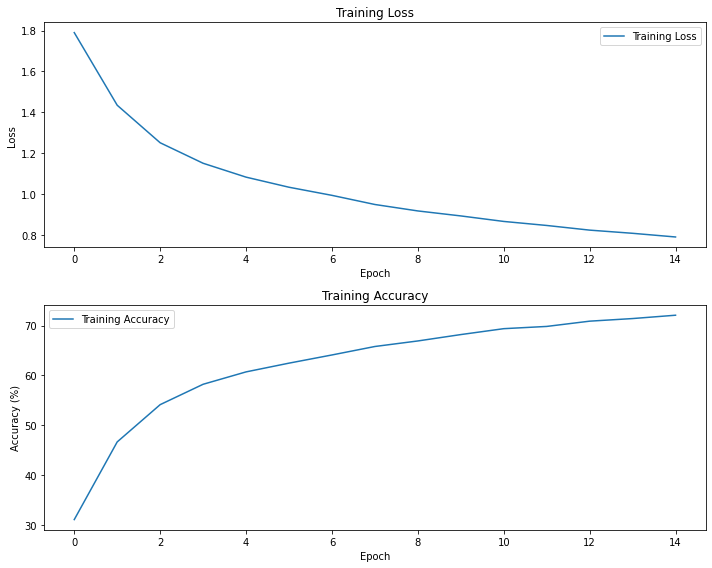

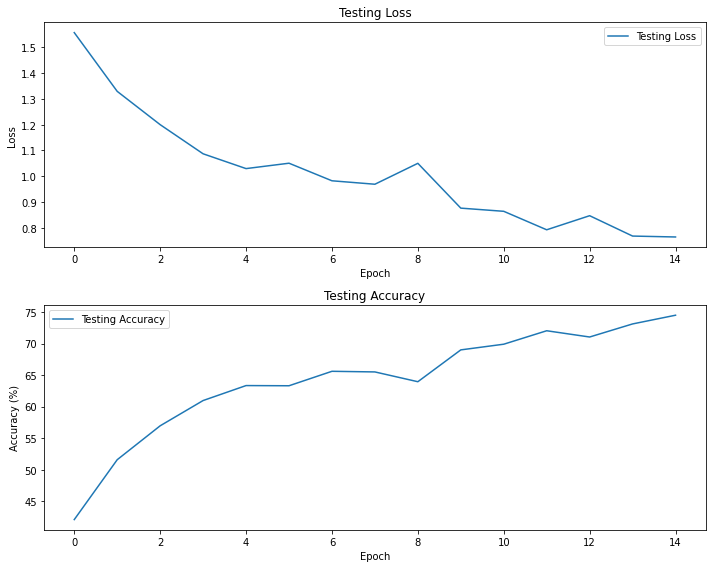

In [9]:
run.train.plot_stats()
run.test.plot_stats()

In [10]:
plot = PlotOutput(model, target_layers=target_layers, device=device)

100%|██████████| 79/79 [00:01<00:00, 41.02it/s]


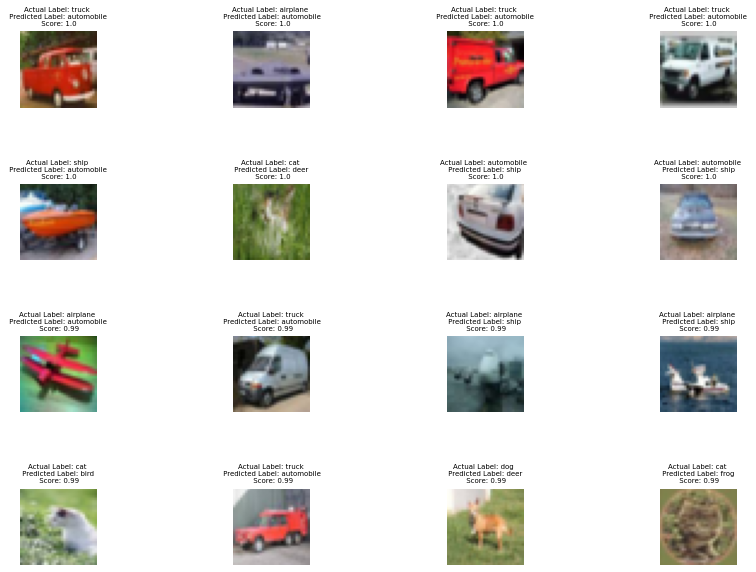

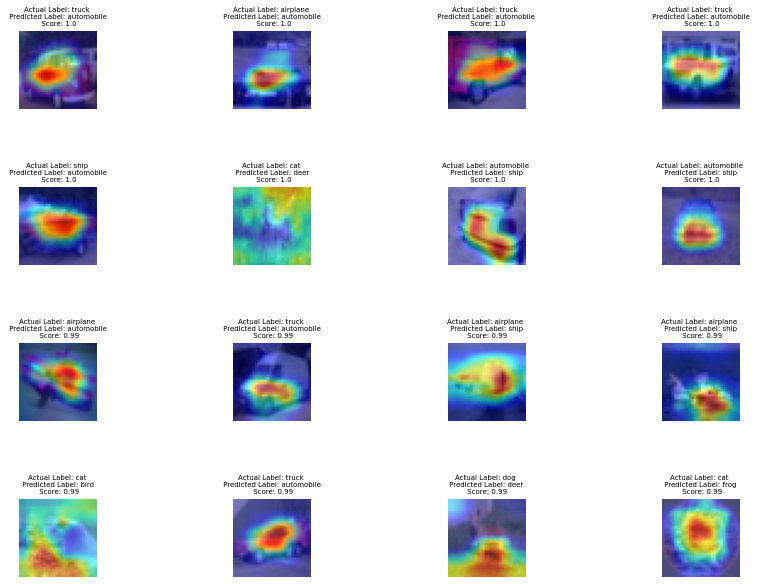

In [11]:
# plot incorrect plus very difficult classifications
plot.run_prediction(test_loader, ptype="incorrect")

plot.plot(n=16, class_list=classes, grad_cam=False)
plot.plot(n=16, class_list=classes, grad_cam=True)

100%|██████████| 79/79 [00:02<00:00, 38.79it/s]


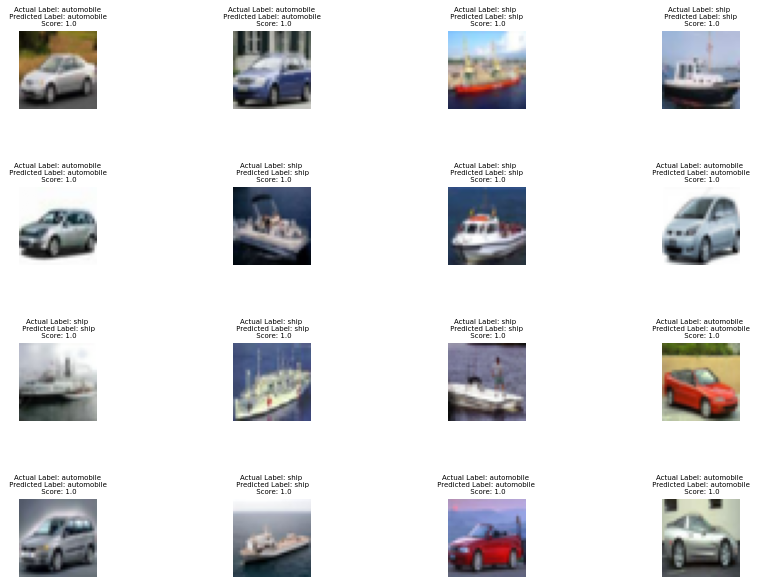

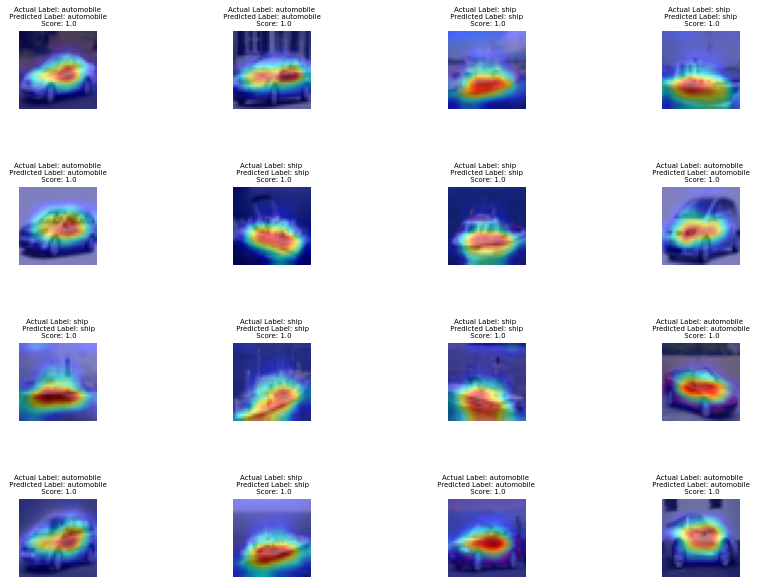

In [12]:
# plot correct yet difficult classifications
plot.run_prediction(test_loader, ptype="correct")

plot.plot(n=16, class_list=classes, grad_cam=False, reverse=True)
plot.plot(n=16, class_list=classes, grad_cam=True, reverse=True)